Saving data at t = 1.00e-03
Saving data at t = 2.00e-03
Saving data at t = 3.00e-03
Saving data at t = 4.00e-03
Saving data at t = 5.00e-03
Saving data at t = 6.01e-03
Saving data at t = 7.01e-03
Saving data at t = 8.01e-03
Saving data at t = 9.01e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

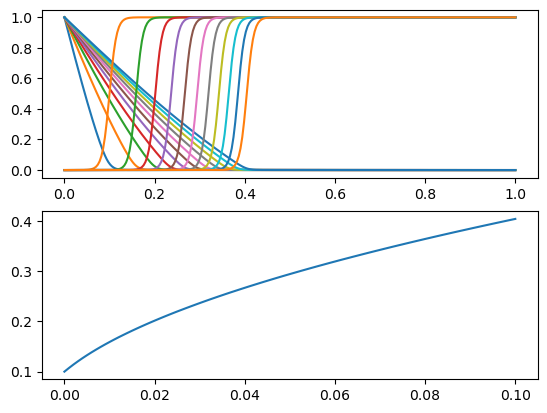

In [1]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar

# Parameters
# ==========
# Number of grid points
Nx = 256 + 1
# Size of domain in x
Lx = 1.0
# x-coordinate vector
x = np.linspace(0, Lx, Nx)
# Grid spacing in x
dx = x[1] - x[0]

# Phase-field parameters
Astar = 128
eps = (1/128)
A = Astar*eps
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi 
phi = 0.5*(1 + np.tanh((x - h)/(2*eps)))

# Initial conditions for T
T = np.zeros(x.size)

T_1plus = np.log(2 * np.cosh((x[x>h] - h) / (2 * eps))) - (x[x>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x[x<h]-h)/eps))
Sv0 = (2*lam**2)/h

T[x<h] = 1.0 - erf(lam*x[x<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
T[x>h] = eps*Sv0*T_1plus # T1_plus
dphi = np.zeros(x.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nx, 101))
T_save = np.zeros((Nx, 101))
phi_save[:, 0] = phi
T_save[:, 0] = T

# Time-stepping parameters
simtime = 0.0   # Current simulation time

#dt = 70*eps**3 # Time step
dt = 0.8*dx**2


t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D)
Lphi = np.eye(Nx) - 0.5*dt*D2phi
D2T = D2(1.0)
LT = np.eye(Nx) - 0.5*dt*D2T

# Temporary arrays for time-stepping
rhs = np.zeros(Nx)
dphi = np.zeros(x.size)
De2 = D/eps**2

iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

def step_time():
    global phi, T
    rhs[:] = dt*D2phi@phi + dt*(
        -De2*phi*(1 - phi)*(1 - 2*phi + A*T)
    )
    rhs[0] = 0.0
    dphi[:] = iLphi@rhs # iLphi @ rhs OR  np.matmul(iLphi,rhs)
    phi += dphi
    rhs[:] = T + 0.5*dt*D2T@T + dphi
    rhs[0] = 1.0
    T[:] = iLT@rhs
    return

import time

t1 = time.time()
# Main loop
while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
        print('Saving data at t = %.2e' % simtime)
        phi_save[:, int(simtime/dt_save)] = phi
        T_save[:, int(simtime/dt_save)] = T
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x, T_save[:,::10])
ax.plot(x, phi_save[:,::10])

h_num = np.array([np.interp(0.5, phi_save[:,i], x) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()


In [3]:
##########################

In [5]:
#np.savez('Asymtotic_N431_eps128', T=T_save, phi=phi_save, dt=dt, eps=eps, h_num=h_num)

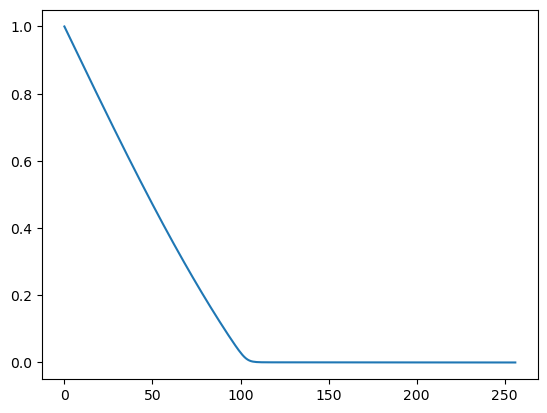

In [7]:
plt.plot(rhs)

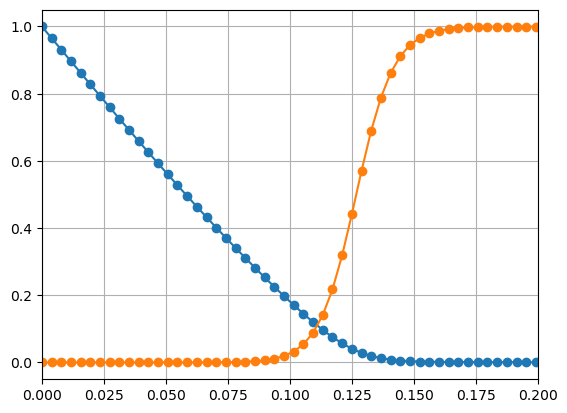

In [9]:
tt = np.linspace(0,0.1,101)
t0 = (h/(2*lam))**2
ha = np.sqrt(tt+t0)*lam*2
plt.plot(x, T_save[:,4],'-o')
plt.plot(x, phi_save[:,4],'-o')
plt.xlim([0,0.2])
plt.grid()
plt.show()

In [11]:
print(dt/dx**2)
print(eps)
print(Sv0)

0.8
0.0078125
7.689553384635683


In [31]:
##################################################################

In [13]:
 #np.savez('Mew2_N1024_eps128', T=T_save, phi=phi_save, dt=dt, eps=eps, h_num=h_num)

In [15]:
######################

# Attempt at T_1

In [18]:
eps = 0.02

T0 = np.zeros(x.size)
T0[x<h] = 1.0 - erf(lam*x[x<h]/h)/erf(lam)  # T0 

T_1plus = np.log(2 * np.cosh((x[x>h] - h) / (2 * eps))) - (x[x>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x[x<h]-h)/eps))

T0_minus = T0[x<h] 
x0_minus = x[x<h]

# Calculate Sv0
Sv0 = T0_minus[-1]/(h-x0_minus[-1])
Sv0


7.758714924694469

In [20]:
Sv0 = (2*lam**2)/h

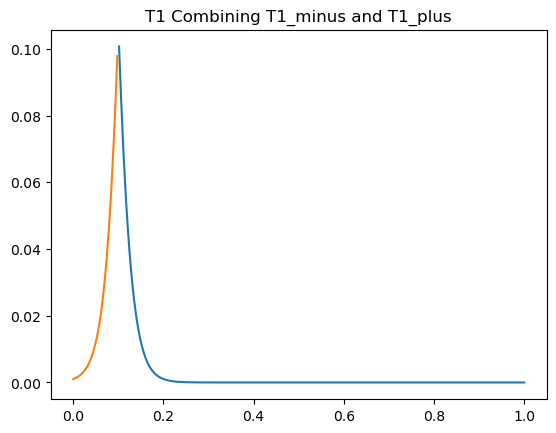

In [22]:
plt.plot(x[x>h],eps*Sv0*T_1plus)
plt.plot(x[x<h],eps*Sv0*T_1minus)
#plt.xlim(0, 0.2)  
plt.title("T1 Combining T1_minus and T1_plus")

T1_combined = np.concatenate((T_1minus, T_1plus))
#plt.plot(x,Sv0*eps*T1_combined)

# New Initial T

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/9h/nmgxk6252393vjm65h0cjxxr0000gn/T/ipykernel_77163/3716832809.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(x,Sv0*eps*T1_combined, color = 'orange', linewidth=2, label = '$\epsilon T_1$')
/var/folders/9h/nmgxk6252393vjm65h0cjxxr0000gn/T/ipykernel_77163/3716832809.py:19: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x,phi, color = 'black', linestyle = '--',linewidth=2, label = '$\phi$')


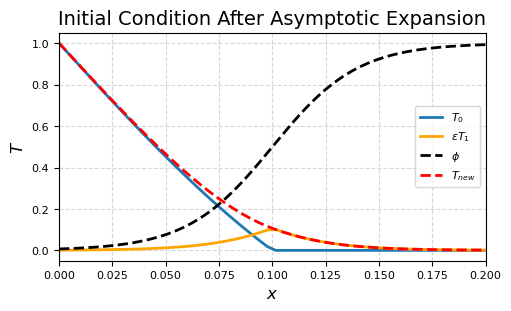

In [24]:
plt.figure(figsize=(5, 3), layout='constrained')

plt.title('Initial Condition After Asymptotic Expansion', fontsize=14)

Ttotal = np.zeros(x.size)

# Tnew = T0 + eps*T1
Ttotal[x<h] = 1.0 - erf(lam*x[x<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
Ttotal[x>h] = eps*Sv0*T_1plus # T1_plus

plt.plot(x, T0,linewidth=2, label = '$T_0$')

# T1
plt.plot(x,Sv0*eps*T1_combined, color = 'orange', linewidth=2, label = '$\epsilon T_1$')
plt.xlim(0, 0.2)  

# phi
phi = 0.5*(1 + np.tanh((x - h)/(2*eps)))
plt.plot(x,phi, color = 'black', linestyle = '--',linewidth=2, label = '$\phi$')

plt.xlabel(r'$x$', fontsize=12)
plt.ylabel('$T$', fontsize=12)

plt.plot(x,Ttotal, color = 'red', linestyle = 'dashed', linewidth=2, label = '$T_{new}$')

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

# Adjust Legend
plt.legend(fontsize=8, loc='best', frameon=True)

#plt.savefig("Asmytotics.pdf", format="pdf")

# Overlap

In [27]:
Sv1 = T0_minus[-1]*dx

# Issue this value is too big
Sv1

7.103315665919025e-05

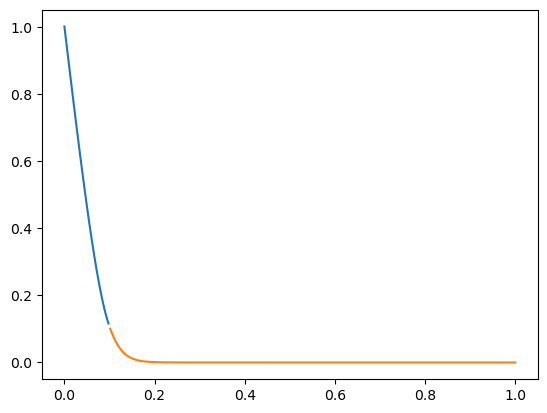

In [29]:
Tcomp = np.zeros(x.size)

Tcomp[x<h] = 1.0 - erf(lam*x[x<h]/h)/erf(lam) + eps*Sv0*T_1minus - x[x<h]*Sv1 # T0 + T1_minus - Overlap
Tcomp[x>h] = eps*Sv0*T_1plus # T1_plus

plt.plot(x[x<h],Tcomp[x<h])
plt.plot(x[x>h],Tcomp[x>h])



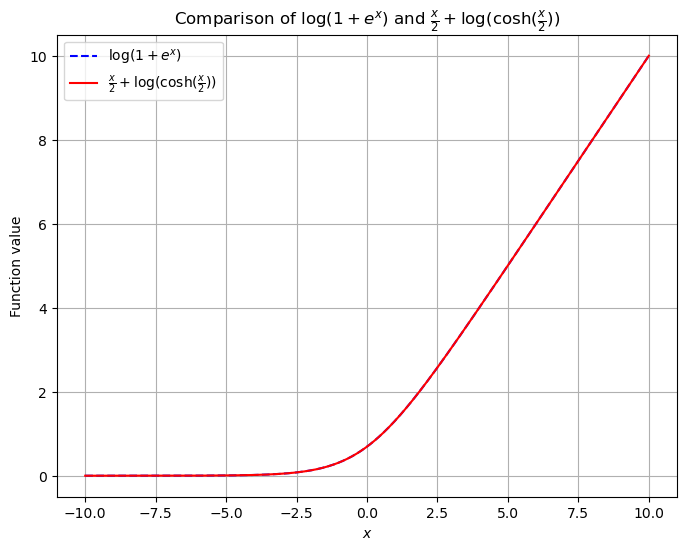

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions to compare
def f1(x):
    return np.log(1 + np.exp(x))

def f2(x):
    return x / 2 + np.log(np.cosh(x / 2)) + np.log(2)

# Generate x values
x = np.linspace(-10, 10, 500)

# Compute y values for both functions
y1 = f1(x)
y2 = f2(x)

# Plot both functions
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label=r"$\log(1 + e^x)$", color="blue", linestyle="--")
plt.plot(x, y2, label=r"$\frac{x}{2} + \log(\cosh(\frac{x}{2}))$", color="red", linestyle="-")
plt.xlabel("$x$")
plt.ylabel("Function value")
plt.title(r"Comparison of $\log(1 + e^x)$ and $\frac{x}{2} + \log(\cosh(\frac{x}{2}))$")
plt.legend()
plt.grid(True)
plt.show()

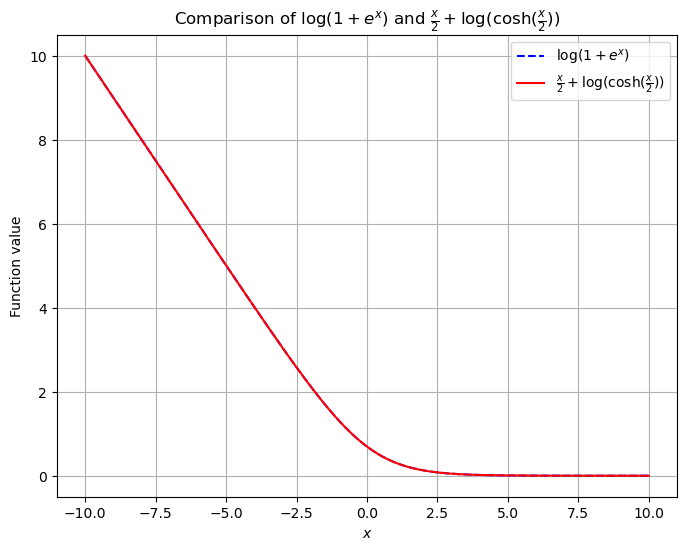

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions to compare
def f1(x):
    return np.log(1 + np.exp(-x))

def f2(x):
    return -x / 2 + np.log(2*np.cosh(x / 2)) 

# Generate x values
x = np.linspace(-10, 10, 500)

# Compute y values for both functions
y1 = f1(x)
y2 = f2(x)

# Plot both functions
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label=r"$\log(1 + e^x)$", color="blue", linestyle="--")
plt.plot(x, y2, label=r"$\frac{x}{2} + \log(\cosh(\frac{x}{2}))$", color="red", linestyle="-")
plt.xlabel("$x$")
plt.ylabel("Function value")
plt.title(r"Comparison of $\log(1 + e^x)$ and $\frac{x}{2} + \log(\cosh(\frac{x}{2}))$")
plt.legend()
plt.grid(True)
plt.show()